In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
#Hyper prameters
EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWNLOAD_MNIST=False

In [3]:
train_data=torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),    #将下载的文件转换成pytorch认识的tensor类型，且将图片的数值大小从（0-255）归一化到（0-1）
    download=DOWNLOAD_MNIST
)

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


102.8%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


112.7%
/opt/conda/envs/pytorch1.8/lib/python3.9/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378073850/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


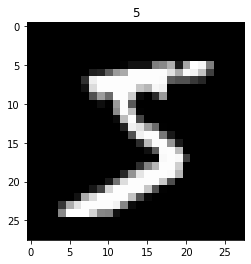

In [4]:
#画一个图片显示出来
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0].numpy(),cmap='gray')
plt.title('%i'%train_data.targets[0])
plt.show()

In [5]:
train_loader=Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

> 设置较大的 batch_size 可能会提高训练速度，但是同时也会增加内存使用量。相反，设置较小的 batch_size 可能会减慢训练速度，但是同时会减少内存使用量。因此，需要根据实际情况来调整 batch_size 的大小。

In [6]:
test_data=torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
)

In [7]:
with torch.no_grad():
    test_x=Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255   #只取前两千个数据吧，差不多已经够用了，然后将其归一化。
    test_y=test_data.targets[:2000]

In [8]:
'''开始建立CNN网络'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        '''
        一般来说，卷积网络包括以下内容：
        1.卷积层
        2.神经网络
        3.池化层
        '''
        self.conv1=nn.Sequential(
            nn.Conv2d(              #--> (1,28,28)
                in_channels=1,      #传入的图片是几层的，灰色为1层，RGB为三层
                out_channels=16,    #输出的图片是几层
                kernel_size=5,      #代表扫描的区域点为5*5
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=2
            ),    # 2d代表二维卷积           --> (16,28,28)
            nn.ReLU(),              #非线性激活层
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值          --> (16,14,14)
        )

        self.conv2=nn.Sequential(
            nn.Conv2d(              #       --> (16,14,14)
                in_channels=16,     #这里的输入是上层的输出为16层
                out_channels=32,    #在这里我们需要将其输出为32层
                kernel_size=5,      #代表扫描的区域点为5*5
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=
            ),                      #   --> (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值     --> (32,7,7)，这里是三维数据
        )

        self.out=nn.Linear(32*7*7,10)       #注意一下这里的数据是二维的数据

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)     #（batch,32,7,7）
        #然后接下来进行一下扩展展平的操作，将三维数据转为二维的数据
        x=x.view(x.size(0),-1)    #(batch ,32 * 7 * 7)
        output=self.out(x)
        return output

In [9]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [10]:
# 添加优化方法
optimizer=torch.optim.Adam(cnn.parameters(),lr=LR)

In [11]:
# 指定损失函数使用交叉信息熵
loss_fn=nn.CrossEntropyLoss()

In [12]:
'''
开始训练我们的模型哦
'''
step=0
for epoch in range(EPOCH):
    #加载训练数据
    for step,data in enumerate(train_loader):
        x,y=data
        #分别得到训练数据的x和y的取值
        b_x=Variable(x)
        b_y=Variable(y)

        output=cnn(b_x)         #调用模型预测
        loss=loss_fn(output,b_y)#计算损失值
        optimizer.zero_grad()   #每一次循环之前，将梯度清零
        loss.backward()         #反向传播
        optimizer.step()        #梯度下降

        #每执行50次，输出一下当前epoch、loss、accuracy
        if (step%50==0):
            #计算一下模型预测正确率
            test_output=cnn(test_x)
            y_pred=torch.max(test_output,1)[1].data.squeeze()
            accuracy=sum(y_pred==test_y).item()/test_y.size(0)

            print('now epoch :  ', epoch, '   |  loss : %.4f ' % loss.item(), '     |   accuracy :   ' , accuracy)

now epoch :   0    |  loss : 2.2950       |   accuracy :    0.1545
now epoch :   0    |  loss : 0.4004       |   accuracy :    0.829
now epoch :   0    |  loss : 0.1852       |   accuracy :    0.879
now epoch :   0    |  loss : 0.1992       |   accuracy :    0.9155
now epoch :   0    |  loss : 0.1494       |   accuracy :    0.933
now epoch :   0    |  loss : 0.1291       |   accuracy :    0.9395
now epoch :   0    |  loss : 0.2756       |   accuracy :    0.9415
now epoch :   0    |  loss : 0.1251       |   accuracy :    0.956
now epoch :   0    |  loss : 0.1288       |   accuracy :    0.9515
now epoch :   0    |  loss : 0.1385       |   accuracy :    0.949
now epoch :   0    |  loss : 0.0505       |   accuracy :    0.9655
now epoch :   0    |  loss : 0.1386       |   accuracy :    0.971
now epoch :   0    |  loss : 0.1096       |   accuracy :    0.963
now epoch :   0    |  loss : 0.1424       |   accuracy :    0.9685
now epoch :   0    |  loss : 0.0925       |   accuracy :    0.971
now

In [13]:
'''
打印十个测试集的结果
'''
test_output=cnn(test_x[:10])
y_pred=torch.max(test_output,1)[1].data.squeeze()       #选取最大可能的数值所在的位置
print(y_pred.tolist(),'predecton Result')
print(test_y[:10].tolist(),'Real Result')

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9] predecton Result
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9] Real Result
